## Cats Vs Dogs

In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt,matplotlib.ticker as mticker
import numpy as np
import cv2
import glob
from glob import glob
%matplotlib inline
device='cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
train_data_dir=r'../data/Ch4/archive/training_set/training_set'
test_data_dir=r'../data/Ch4/archive/test_set/test_set'
class cats_dogs(Dataset):
    def __init__(self,folder):
        cats=glob(folder+'/cats/*.jpg')
        dogs=glob(folder+'/dogs/*.jpg')
        self.fpaths=cats+dogs
        from random import shuffle,seed
        seed(10),shuffle(self.fpaths)
        self.targets=[fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]  # dog=1 & cat=0
    def __len__(self):
        return len(self.fpaths)
    def __getitem__(self, item):
        f=self.fpaths[item]
        target=self.targets[item]
        # 读取图像文件，并将其颜色通道从 BGR 转换为 RGB
        im = (cv2.imread(f)[:,:,::-1])
        # 将读取的图像调整为 224x224 的大小
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(),torch.tensor([target]).float().to(device)

In [3]:
data=cats_dogs(train_data_dir)
im,label=data[200]

In [4]:
len(data)

8005

tensor([1.], device='cuda:0')


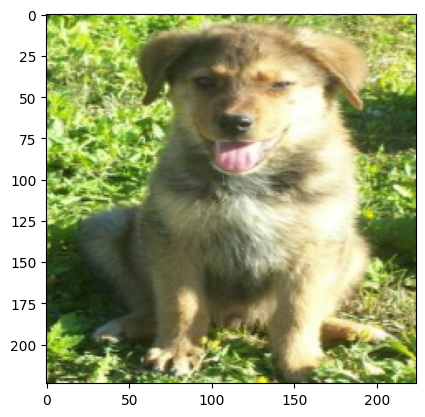

In [5]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [6]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
        nn.Conv2d(ni,no,kernel_size,stride),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )
def get_model():
    model=nn.Sequential(
        conv_layer(3,64,3),
        conv_layer(64,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        nn.Flatten(),
        nn.Linear(512,1),
        nn.Sigmoid()
    ).to(device)
    loss_fn=nn.BCELoss()
    optimizer=optim.Adam(model.parameters(),lr=1e-3)
    return model,loss_fn,optimizer

In [7]:
model,loss_fn,optimizer=get_model()
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [8]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    batch_loss=loss_fn(model(x),y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def accuracy(x,y,model):
    model.eval()
    with torch.no_grad():
        prediction=model(x)
    is_correct=(prediction>0.5)==y
    return is_correct.cpu().numpy().tolist()

def get_data():
    train=cats_dogs(train_data_dir)
    trn_dl=DataLoader(train,batch_size=32,shuffle=True,drop_last=True)
    val=cats_dogs(test_data_dir)
    val_dl=DataLoader(val,batch_size=32,shuffle=True,drop_last=True)
    return trn_dl,val_dl

@torch.no_grad()
def val_loss(x,y,model,loss_fn):
    model.eval()
    val_loss=loss_fn(model(x),y)
    return val_loss.item()

In [9]:
trn_dl,val_dl=get_data()

In [10]:
train_losses,train_accuracies=[],[]
val_losses,val_accuracies=[],[]
for epoch in range(5):
    print(epoch)
    train_epoch_losses,train_epoch_accuracies=[],[]
    val_epoch_accuracies=[]
    for ix,batch in enumerate(iter(trn_dl)):
        x,y=batch
        batch_loss=train_batch(x,y,model,optimizer,loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss=np.array(train_epoch_losses).mean()
    for ix,batch in enumerate(iter(trn_dl)):
        x,y=batch
        is_correct=accuracy(x,y,model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy=np.mean(train_epoch_accuracies)
    for ix,batch in enumerate(iter(val_dl)):
        x,y=batch
        val_is_correct=accuracy(x,y,model)
        # validation_loss=val_loss(x,y,model,loss_fn)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy=np.mean(val_epoch_accuracies)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    # val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


In [11]:
len(train_epoch_accuracies)

8000

In [12]:
len(train_epoch_accuracies[0])

1

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28688\3839548402.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])


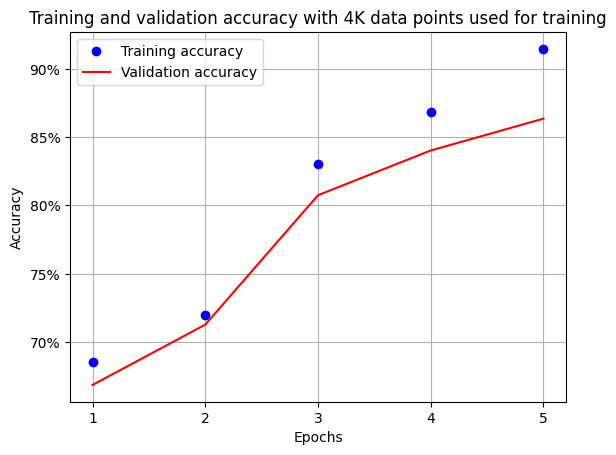

In [13]:
epochs = np.arange(5)+1
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [14]:
class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
    def __len__(self): 
        return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [15]:
trn_dl, val_dl = get_data()
model,loss_fn,optimizer=get_model()

In [16]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_1k = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        # validation_loss = val_loss(x, y, model,loss_fn)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    # val_losses.append(validation_loss)
    val_accuracies_1k.append(val_epoch_accuracy)

0
1
2
3
4


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28688\3642398333.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])


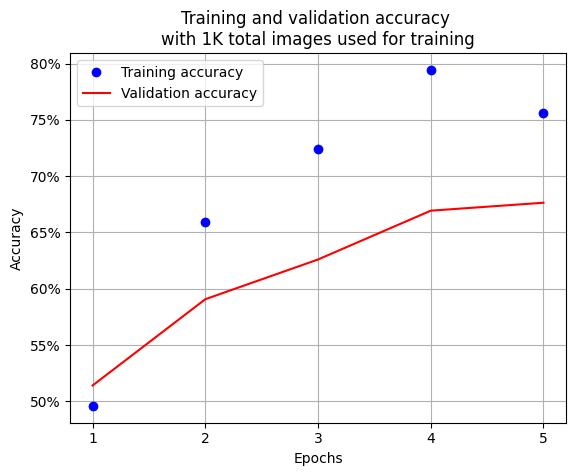

In [17]:
epochs = np.arange(5)+1
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies_1k, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \nwith 1K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [18]:
class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:1000] + dogs[:1000]
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
    def __len__(self): 
        return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [19]:
trn_dl, val_dl = get_data()
model,loss_fn,optimizer=get_model()

In [20]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_2k = [], []
for epoch in range(5):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies_2k.append(val_epoch_accuracy)

0
1
2
3
4


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28688\2055134617.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])


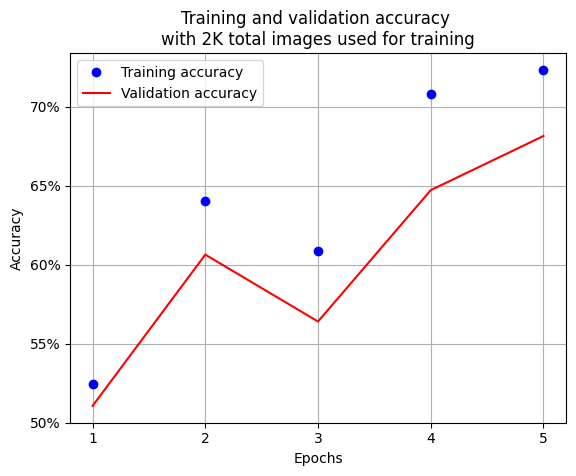

In [21]:
epochs = np.arange(5)+1
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies_2k, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \nwith 2K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [22]:
class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder + '/cats/*.jpg')
        dogs = glob(folder + '/dogs/*.jpg')
        self.fpaths = cats[:2000] + dogs[:2000]
        from random import shuffle, seed;  
        seed(10);
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]  # dog=1 & cat=0
    def __len__(self): 
        return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:, :, ::-1])
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), torch.tensor([target]).float().to(device)

In [23]:
trn_dl, val_dl = get_data()
model,loss_fn,optimizer=get_model()

In [24]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_4k = [], []
for epoch in range(5):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies_4k.append(val_epoch_accuracy)

0
1
2
3
4


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28688\2315764381.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])


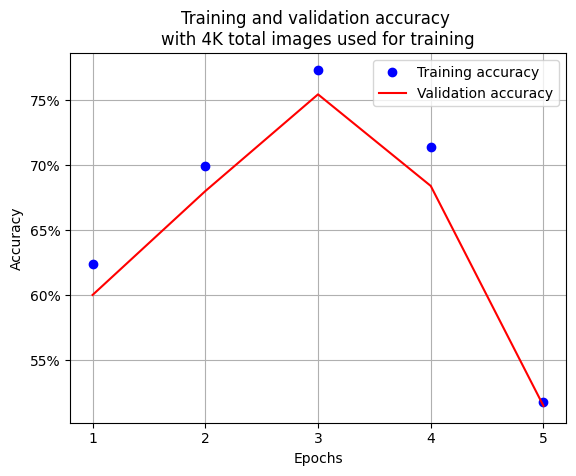

In [25]:
epochs = np.arange(5)+1
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies_4k, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \nwith 4K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28688\4249837366.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


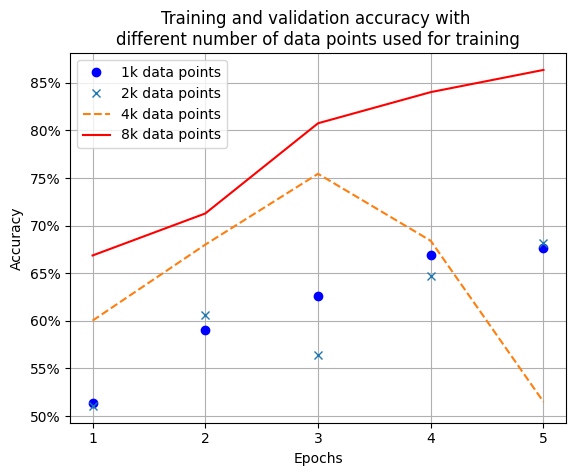

In [26]:
epochs = np.arange(5)+1
plt.plot(epochs, val_accuracies_1k, 'bo', label='1k data points')
plt.plot(epochs, val_accuracies_2k, 'x', label='2k data points')
plt.plot(epochs, val_accuracies_4k, '--', label='4k data points',markersize = 20)
plt.plot(epochs, val_accuracies, 'r', label='8k data points')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with \ndifferent number of data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()